# 0. Exploratory Data Analysis (EDA)

Resources:
- ChatGPT
- ClaudeAI
- OpenCV docs
- numpy docs
- matplotlib docs

It would be naïve not to leverage the assimilation of good computer-vision code-practices from a Large Language Model (LLM).

Note that every code block here has been typed out by hand.

Best,
Aayush

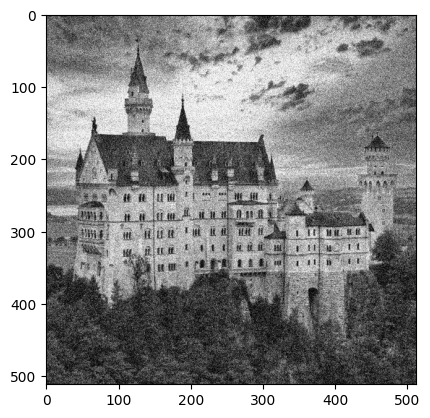

Dimensions:  (512, 512, 3)


In [328]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./Castle01.jpg")
plt.imshow(img)
plt.show()
print("Dimensions: ", img.shape)

## Plotting the other 9 images in a 3x3 subplot.

In [ ]:
image_list = [f'Castle{str(i).zfill(2)}.jpg' for i in range(2,11)]
image_list

['Castle02.jpg',
 'Castle03.jpg',
 'Castle04.jpg',
 'Castle05.jpg',
 'Castle06.jpg',
 'Castle07.jpg',
 'Castle08.jpg',
 'Castle09.jpg',
 'Castle10.jpg']

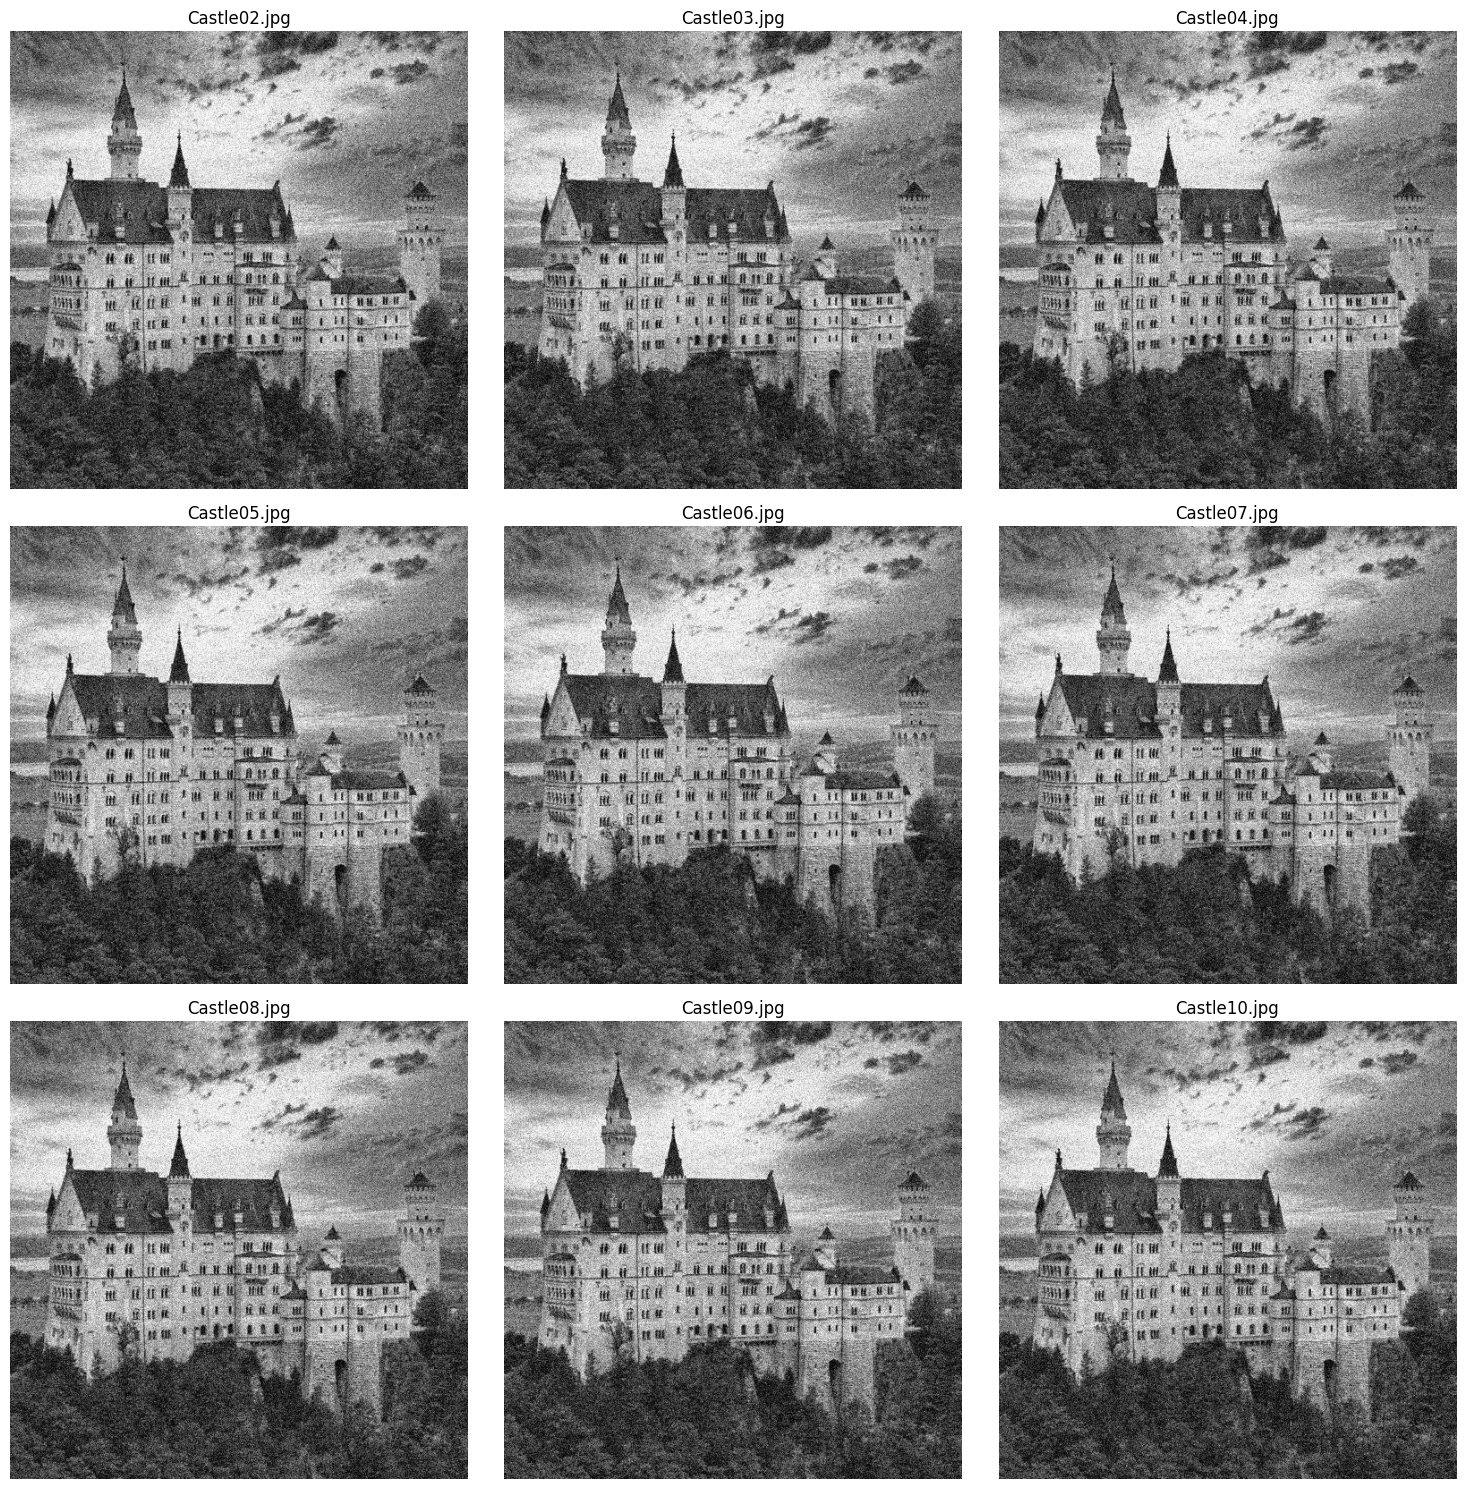

In [ ]:
import os

fig, axes = plt.subplots(3,3, figsize=(15,15))
axes = axes.ravel() # unroll axes for indexing ease

image_list = [f'Castle{str(i).zfill(2)}.jpg' for i in range(2,11)]

for i, file in enumerate(image_list):
    img_path = os.path.join('.', file)
    img_sub = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # change the grayscales around later

    if img is None:
        print(f"failed to print {file} at {img_path}")
        continue

    axes[i].imshow(img_sub, cmap='gray')
    axes[i].set_title(file)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Investigating sub-regions

In [ ]:
x = 2
y = 1
print(img[1])

[[ 80  80  80]
 [ 61  61  61]
 [ 41  41  41]
 ...
 [108 108 108]
 [129 129 129]
 [169 169 169]]


In [ ]:
""" it seems that the dimensionality of the objects should be manipulated to
[ [38, 62, 96, ..., 131, 157, 158],
  [80, 61, 41, ..., 108, 129, 169],
]
"""
img = cv2.imread(os.path.join('.', "Castle01.jpg"), cv2.IMREAD_GRAYSCALE)
print(f"dim: {img.shape}")
print(img[:4])

dim: (512, 512)
[[ 38  62  96 ... 131 157 158]
 [ 80  61  41 ... 108 129 169]
 [ 18  71  73 ... 129  80  79]
 [114  67  98 ... 158 139 132]]


### Lambda Function for plotting top_left

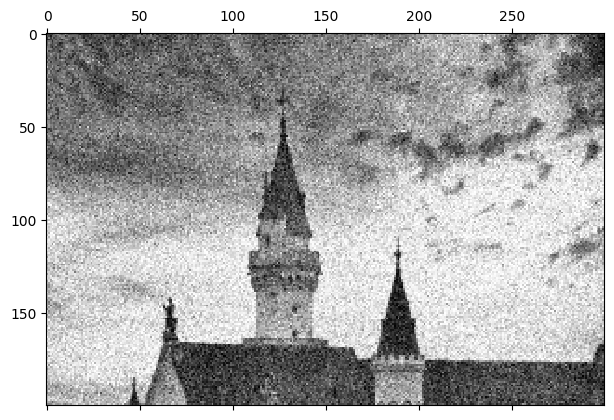

In [ ]:
top_left = lambda x, y: img[0:y,0:x]
plt.matshow(top_left(300,200), cmap='gray')

## Slicing
- note plt.matshow will not work from within a function. it needs an axis to draw on!

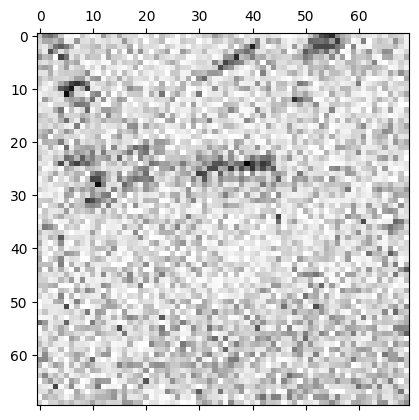

In [ ]:
img_slice = img[90:160,200:270]
plt.matshow(img_slice, cmap="gray")
plt.show()

## Intensities Frequency Histogram

In [ ]:
start_max = 0
for i in range(len(img)):
    loop_max = max(img[i])
    if loop_max > start_max:
        start_max = loop_max
print(start_max)

255


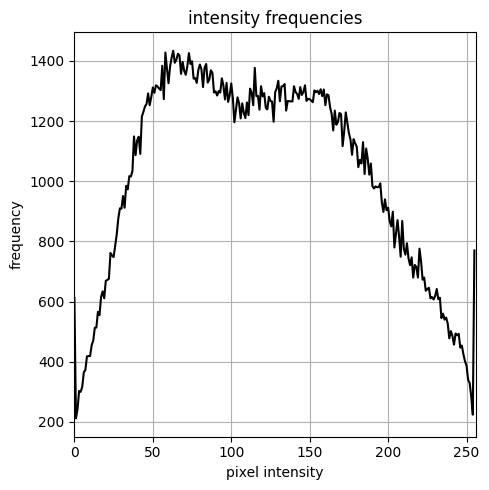

In [ ]:
import numpy as np

hist = cv2.calcHist([img], [0], None, [256], [0, 256])

plt.figure(figsize=(5,5))
plt.title("intensity frequencies")
plt.xlabel("pixel intensity")
plt.ylabel("frequency")
plt.plot(hist, color='black')
plt.xlim([0,256])
plt.grid(True)
plt.tight_layout()
plt.show()


## Last visualisation I promise mum

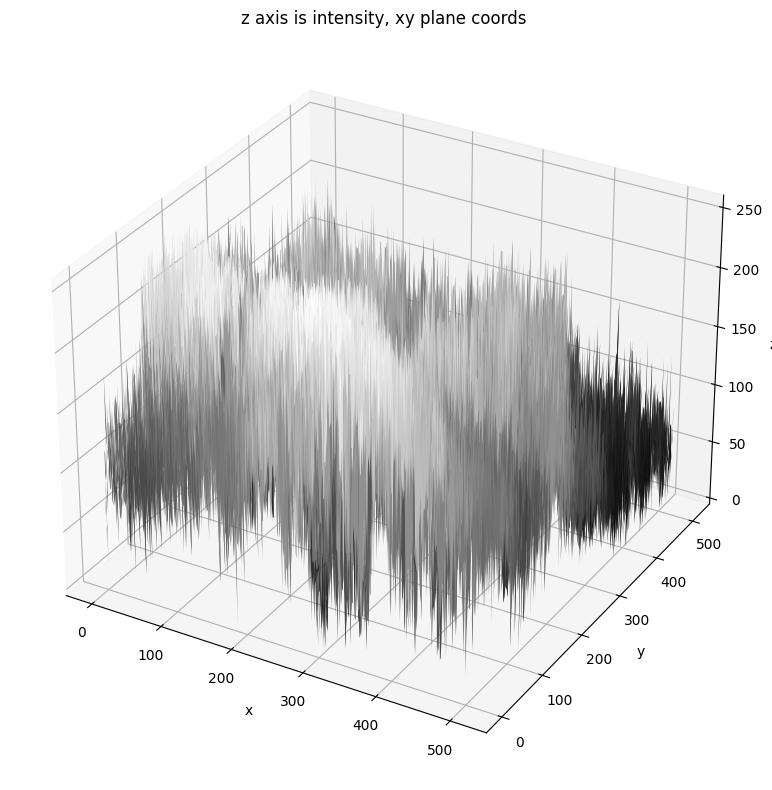

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

x=np.arange(0, img.shape[1])     # note this is backwards in computer vision because x ------> (columns)
y=np.arange(0, img.shape[0])     #                                                   y
X, Y = np.meshgrid(x, y)         #                                                   |
fig = plt.figure(figsize=(10,8)) #                                                   |
ax = fig.add_subplot(111, projection='3d') #                                         |
ax.plot_surface(X, Y, img, cmap='gray', edgecolor='none') #                           v
ax.set_title('z axis is intensity, xy plane coords') #                               = (rows)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()

### holy crap, check out the top angle!
it looks exactly like the original image!
<div>
<img src="./3d-illum.png" width="400">
</div>

(note to marker: if at this point you cannot realise that this is almost entirely my own work you might be damaged. c.f. abaj.ai for intellectual evidence of the mastery of this content.)


# 1. Averaging

todo:
- [X] calculate average of 10 images
- [X] how much noise reduction is theoretically possible? (what factor should the std dev of the noise drop?)
- [X] how much noise reduction was actually accomplished?
    - [X] measure std dev in white part of sky for averaged and noisy images. compare them.

## intensity thresholding (for fun)

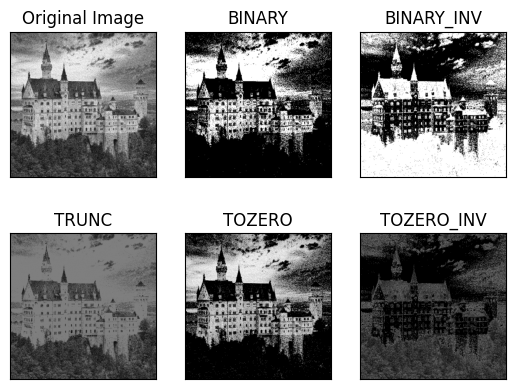

In [ ]:
ret,thresh1 = cv2.threshold(img,155,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
 
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
 
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
 
plt.show()

## averaging subplots (the actual task 😅)

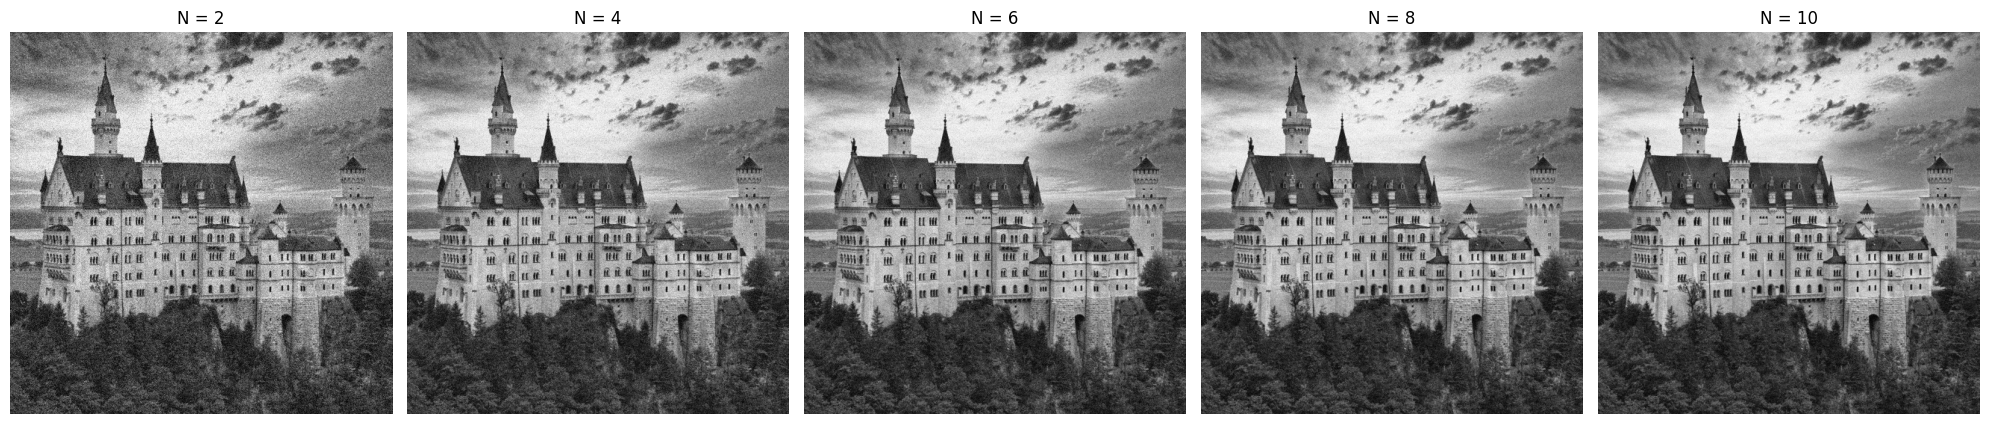

In [ ]:
image_list_all = [f'Castle{str(i).zfill(2)}.jpg' for i in range(1,11)]
images = []
for file in image_list_all:
    img_i = cv2.imread(os.path.join('.', file), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"failed to load {img_i}")
    else:
        images.append(img_i.astype(np.float32)) # using np floats for averaging.

N_values = [2, 4, 6, 8, 10]

fig, axes = plt.subplots(1, 5, figsize=(20,5))
for ax, N in zip(axes, N_values):
    avg_img = np.mean(images[:N], axis=0) # average first N images, where we index on N
    avg_img = np.clip(avg_img, 0, 255).astype(np.uint8) # convert back for plotting

    ax.imshow(avg_img, cmap='gray')
    ax.set_title(f'N = {N}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Theoretical Noise Reduction

We know that *standard deviation* is equal to $\sigma$, and that our original image has variance composed of the i.i.d errors $n_i$:

\begin{align}
\text{VAR}\left[\frac{1}{N}\sum_{i=1}^{N} n_i(x,y)\right] &= \frac{\sigma^2(x,y)}{N}\\
\Rightarrow \text{STD} &= \frac{\sigma(x,y)}{\sqrt{N}}
\end{align}

Thus, theoretically we are able to achieve noise reduction by a factor of $$\frac{1}{\sqrt{N}}$$

(note to marker: I am taking MATH3611 and MATH2901 at the moment; this mathematics is trivial to me.)


### Empirical Noise Reduction
we are going to use the below rectangle of sky for measurements!

(512, 512)


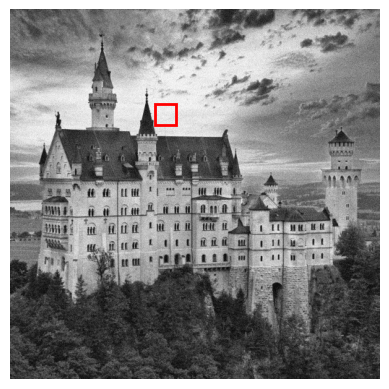

In [ ]:
img = cv2.imread("./CastleAveraged.jpg", cv2.IMREAD_GRAYSCALE) # just to make sure.
print(img.shape)
# slice co-ords.
top, bottom = 130, 160
left, right = 200, 230
width = right - left
height = bottom - top

fig, ax = plt.subplots()
ax.imshow(img)

rect = plt.Rectangle((left, top), width, height,
                     linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.axis('off')
plt.imshow(img, cmap='gray') # import cmap!
plt.show()


## measuring std

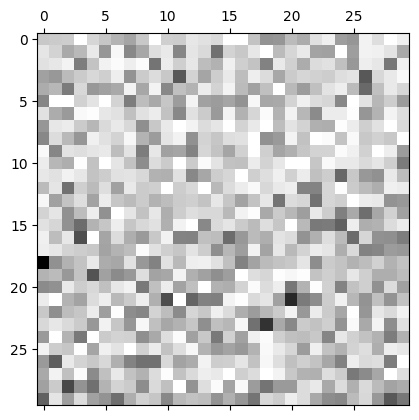

In [ ]:
img_slice = img[130:160,200:230] # [y_start: y_end, x_start: x_end]
plt.matshow(img_slice, cmap="gray")
plt.show() # of this patch of sky:

In [ ]:
x, y, w, h = 200, 130, 30, 30
std_orig = np.std(images[0][y:y+h, x:x+w])

avg_img = np.mean(images[:10], axis=0)
std_avg = np.std(avg_img[y:y+h, x:x+w])

theoretical = std_noisy / np.sqrt(N)
actual = std_avg
ratio = actual / theoretical

print(f"Results:")
label_width = 23
print(f"\t{'Theoretical STD':<{label_width}} = {theoretical:.2f}")
print(f"\t{'Actual STD':<{label_width}} = {actual:.2f}")
print(f"\t{'Ratio (actual / theory)':<{label_width}} = {ratio:.2f}")

Results:
	Theoretical STD         = 11.35
	Actual STD              = 6.67
	Ratio (actual / theory) = 0.59


## bonus marks, for N = 2, 4, 6, 8:

In [ ]:
import pandas as pd

results = []

for N in [2, 4, 6, 8, 10]:
    avg_img = np.mean(images[:N], axis=0)
    std_avg = np.std(avg_img[y:y+h, x:x+w])
    
    theoretical = std_noisy / np.sqrt(N)
    actual = std_avg
    ratio = actual / theoretical

    results.append({
        'N': N,
        'Theoretical STD': theoretical,
        'Actual STD': actual,
        'Ratio': ratio
    })

df = pd.DataFrame(results)
print(df)

    N  Theoretical STD  Actual STD     Ratio
0   2        25.374027   13.246527  0.522051
1   4        17.942146    9.642165  0.537403
2   6        14.649701    8.121696  0.554393
3   8        12.687013    7.222329  0.569269
4  10        11.347610    6.668942  0.587696


## discussion
we obtained an empirical standard deviation reduction of about $1/2$.

## saving the averaged file

In [ ]:
image_list_all = [f'Castle{str(i).zfill(2)}.jpg' for i in range(1,11)]
images = []
for file in image_list_all:
    img_i = cv2.imread(os.path.join('.', file), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"failed to load {img_i}")
    else:
        images.append(img_i.astype(np.float32)) # using np floats for averaging.

N = 10
avg_img = np.mean(images[:N], axis=0) # average first N images, where we index on N
#avg_img = np.clip(avg_img, 0, 255).astype(np.uint8) # convert back for plotting
print(avg_img)
print(avg_img.shape)
print(type(avg_img))
print(avg_img.dtype)
#cv2.imwrite('CastleAveraged.jpg', avg_img) # NEWSFLASH: JPG does not store bigger than UINT8 !!!
#cv2.imwrite('CastleAveraged.png', avg_img) # this doesn't work either :(
np.save('CastleAveraged.npy', avg_img)  # saves as float32 (or whatever dtype)

[[ 75.9  81.4  61.8 ... 127.2 115.2 119.7]
 [ 80.   75.   61.7 ... 115.3 117.1 130.6]
 [ 67.8  87.4  87.8 ... 118.  120.8  99.7]
 ...
 [ 46.6  55.3  84.6 ...  51.9  57.8  47.5]
 [ 67.6  64.   56.7 ...  43.7  45.6  66.8]
 [ 53.6  43.8  42.3 ...  35.   52.1  50.8]]
(512, 512)
<class 'numpy.ndarray'>
float32


# 2. DoG
todo:
    - given the averaged image, convolve the difference of f with h1 and h2.

## loading avg img

In [ ]:
#####
# loading from CastleAveraged.npy:
avg_img = np.load('CastleAveraged.npy')
print(avg_img)
avg_img.shape
avg_img.dtype

[[ 75.9  81.4  61.8 ... 127.2 115.2 119.7]
 [ 80.   75.   61.7 ... 115.3 117.1 130.6]
 [ 67.8  87.4  87.8 ... 118.  120.8  99.7]
 ...
 [ 46.6  55.3  84.6 ...  51.9  57.8  47.5]
 [ 67.6  64.   56.7 ...  43.7  45.6  66.8]
 [ 53.6  43.8  42.3 ...  35.   52.1  50.8]]


dtype('float32')

## convolving f with h1 and h2 in subplot

In [ ]:
unnorm_h1 = np.array([
    [0,0,0,0,0],
    [0,1,2,1,0],
    [0,2,4,2,0],
    [0,1,2,1,0],
    [0,0,0,0,0]
], dtype=np.float32)

unnorm_h2 = np.array([
    [1,4,6,4,1],
    [4,16,24,16,4],
    [6,24,36,24,6],
    [4,16,24,16,4],
    [1,4,6,4,1]
], dtype=np.float32)

h1 = unnorm_h1 / unnorm_h1.sum()  # divide by 16
h2 = unnorm_h2 / unnorm_h2.sum()  # divide by 256


In [ ]:
conv_h1 = cv2.filter2D(avg_img, -1, h1)
conv_h2 = cv2.filter2D(avg_img, -1, h2)

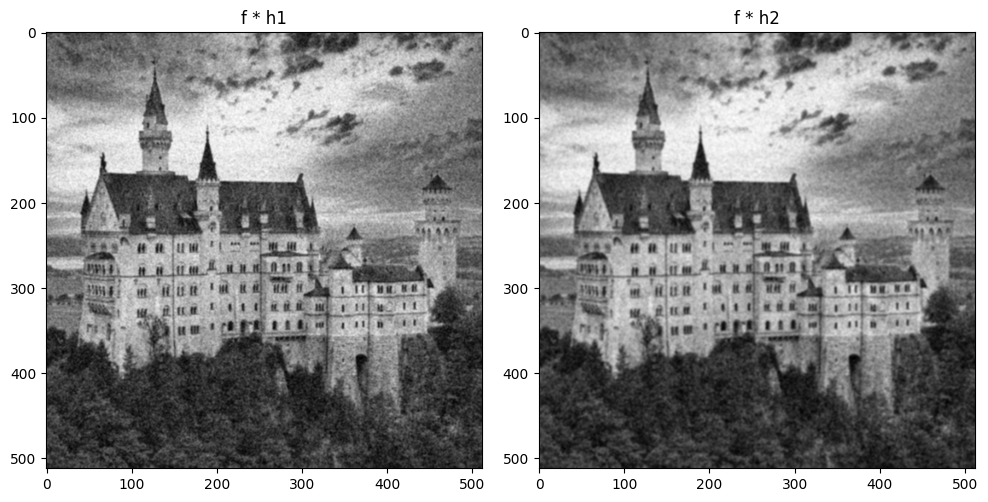

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(conv_h1, cmap='gray')
axes[0].set_title('f * h1')
axes[1].imshow(conv_h2, cmap='gray')
axes[1].set_title('f * h2')
#for ax in axes:
#    ax.axis('off')
plt.tight_layout()
plt.show()


## okay applying the DoG

In [ ]:
img_float = img.astype(np.float32)

# Filter using float32 precision
conv_h1 = cv2.filter2D(img_float, -1, h1)
conv_h2 = cv2.filter2D(img_float, -1, h2)

# convolution of the difference (FAST)
dog_kernel = h1 - h2
conv_dog_1 = cv2.filter2D(img_float, -1, dog_kernel)

# difference of the convolutions (SLOW)
conv_dog_2 = conv_h1 - conv_h2

# Check max absolute difference
np.max(np.abs(conv_dog_1 - conv_dog_2))  # should be ~0



np.float32(0.0)

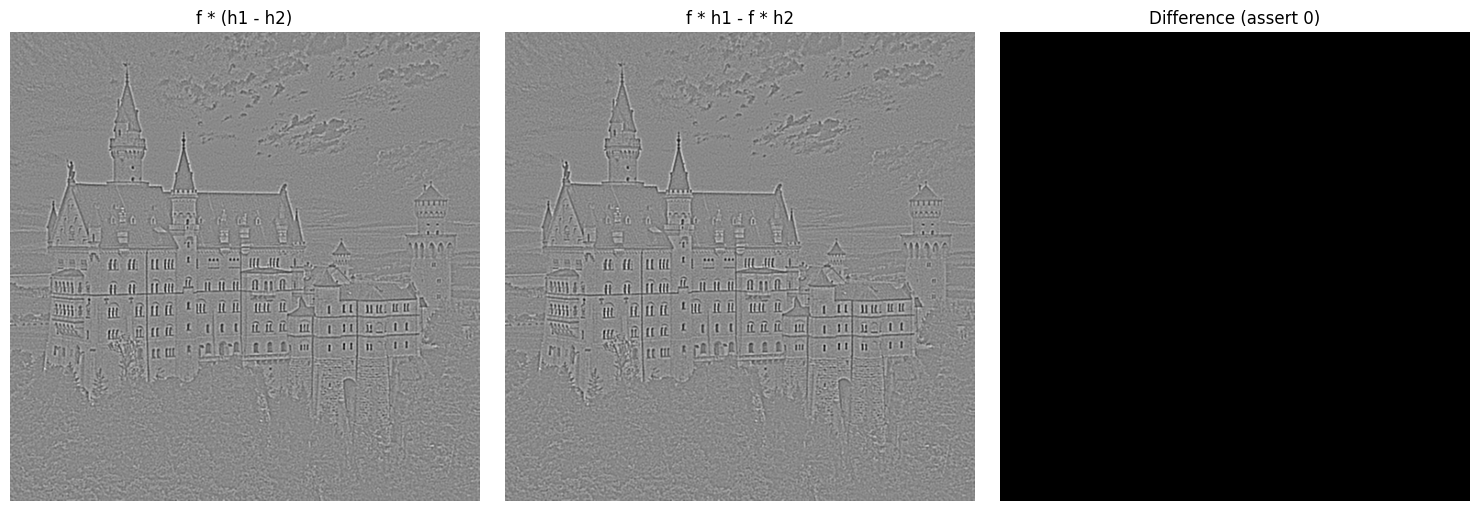

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(conv_dog_1, cmap='gray')
axes[0].set_title('f * (h1 - h2)')
axes[1].imshow(conv_dog_2, cmap='gray')
axes[1].set_title('f * h1 - f * h2')
axes[2].imshow(np.abs(conv_dog_1 - conv_dog_2), cmap='gray')
axes[2].set_title('Difference (assert 0)')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


## analysis
the computation difference exists because doing 1 convolution is cheaper than 2 convolutions (why?).

the distributivity of the convolution guarantees the results are the same.

## saving the fast conv

In [ ]:
np.save('CastleDoG.npy', conv_dog_1)  # saves as float32 (or whatever dtype)
cv2.imwrite('CastleDoG.jpg', conv_dog_1)

True

# 3. Discrete FFT
seems simple enough:
- [X] compute the magnitude of 2d transform for averaging
- [X] do same for dog
- [X] explain the difference

## loading data

[[ 1.4375     -1.1953125  -3.734375   ...  0.8125      0.859375
   1.125     ]
 [ 0.5234375  -0.453125   -1.453125   ... -0.21875    -0.48046875
  -0.359375  ]
 [-1.0234375  -0.0078125   0.875      ... -0.3671875  -1.4023438
  -2.2109375 ]
 ...
 [ 0.6875      1.5625      4.2773438  ...  0.640625    1.3945312
   1.515625  ]
 [ 0.015625   -0.38671875  0.34375    ... -0.34765625  2.265625
   2.921875  ]
 [ 0.140625   -2.7109375  -5.109375   ... -2.5         0.8984375
   2.25      ]]


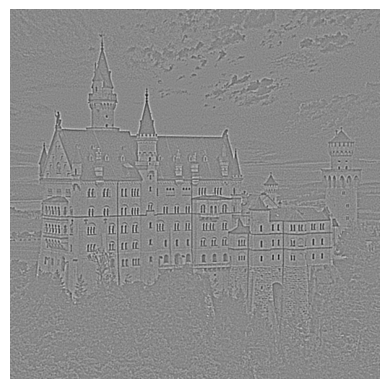

In [ ]:
dog_img = np.load('CastleDoG.npy')
print(dog_img)
dog_img.shape
plt.imshow(dog_img, cmap='gray')
plt.axis('off')
plt.show()

[[ 75.9  81.4  61.8 ... 127.2 115.2 119.7]
 [ 80.   75.   61.7 ... 115.3 117.1 130.6]
 [ 67.8  87.4  87.8 ... 118.  120.8  99.7]
 ...
 [ 46.6  55.3  84.6 ...  51.9  57.8  47.5]
 [ 67.6  64.   56.7 ...  43.7  45.6  66.8]
 [ 53.6  43.8  42.3 ...  35.   52.1  50.8]]


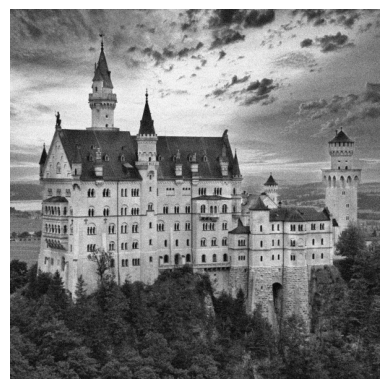

In [ ]:
avg_img = np.load('CastleAveraged.npy')
print(avg_img)
avg_img.shape
plt.imshow(avg_img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
## applying transforms
print(avg_img - dog_img)

[[ 74.4625    82.595314  65.53438  ... 126.3875   114.34062  118.575   ]
 [ 79.47656   75.453125  63.153126 ... 115.51875  117.58047  130.95938 ]
 [ 68.82344   87.407814  86.925    ... 118.36719  122.20235  101.910934]
 ...
 [ 45.9125    53.7375    80.322655 ...  51.259377  56.405468  45.984375]
 [ 67.58437   64.38672   56.35625  ...  44.047657  43.334373  63.878128]
 [ 53.459373  46.510937  47.409374 ...  37.5       51.20156   48.55    ]]


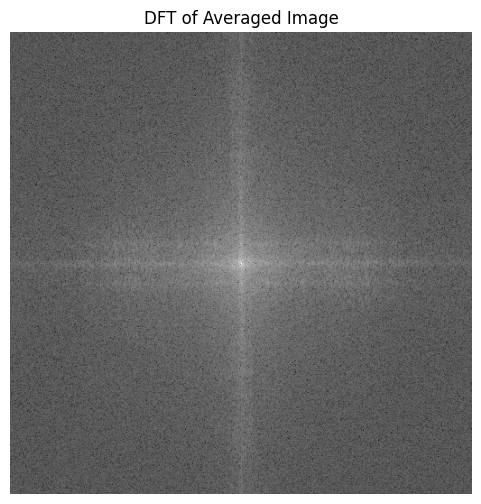

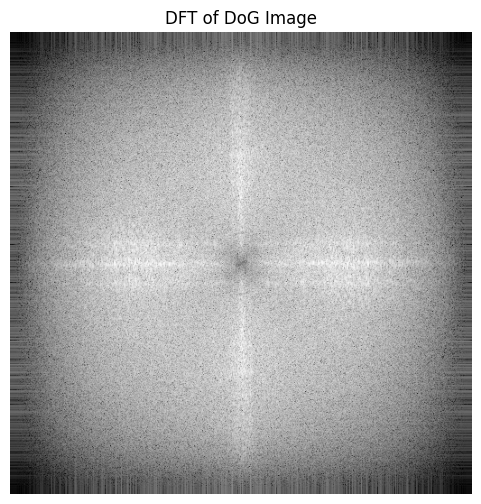

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_float = avg_img
def show_dft(image, title="DFT Magnitude Spectrum"):

    f = np.fft.fft2(image)
    
    # shift zero-frequency to center
    fshift = np.fft.fftshift(f)
    
    # compute magnitude spectrum
    magnitude_spectrum = np.abs(fshift)
    
    # use log scale for visibility
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)

    plt.figure(figsize=(6,6))
    plt.imshow(magnitude_spectrum_log, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.savefig(f"{title}.jpg")
    plt.show()
    
    return fshift, magnitude_spectrum_log

_ = show_dft(img_float, title="DFT of Averaged Image")
_ = show_dft(conv_dog_1, title="DFT of DoG Image")


## Discussion

Here is what the 2 images look like:

<div style="display: flex; justify-content: center; gap: 20px;">
    <figure style="margin: 0; text-align: center;">
        <img width="480px" src="./DFT of Averaged Image.jpg">
        <figcaption>Part 1: DFT of Averaged Image</figcaption>
    </figure>
    <figure style="margin: 0; text-align: center;">
        <img width="480px" src="./DFT of DoG Image.jpg">
        <figcaption>Part 2: DFT of DoG Image</figcaption>
    </figure>
</div>


Image 1: Part 1:

Recall that our _aim_ was to reduce the high-frequency noises from the images by a factor of $1/\sqrt{n}$. We did this by applying a low-pass filter in the **frequency domain**.

Inspecting the first image (on the left above), we have an image the demonstrates "centering" of the _low_ frequencies, and a "darkening effect" as we move outwards. This represents an increase in the dulling of the high-frequency edges / noises.

Image 2: Part 2:

The result of applying the Difference of Gaussians (DoG) (which turns out to be a "bandpass edge detector"):

- Central Dipl there’s a dark spot in the middle => low frequencies are suppressed, which is what DoG does — it removes slow-varying regions.
- Mid-to-High Frequencies Boosted: the image is much brighter overall, especially in the radial band surrounding the center. This shows enhancement of edges and fine details.

Ultimately, what the DoG filter has accomplished is that areas where the image changes abruptly are emphasised. These areas are (naturally) edges and smaller details.

This table is an effect summary of our work in this Notebook:
|                      | Averaged Image  | DoG Image                |
| -------------------- | --------------- | ------------------------ |
| **Low Frequencies**  | Strong          | Suppressed               |
| **High Frequencies** | Weak (denoised) | Boosted (edges/textures) |
| **Center of DFT**    | Bright          | Dark                     |
| **Visual Goal**      | Smooth, clean   | Highlights structure     |
